In [80]:
%pip install hmmlearn
%pip install eyed3
%pip install pyAudioAnalysis
%pip install pydub
%pip install librosa
%pip install -U nltk
%python -m nltk.downloader 'popular'
%pip install -U pywsd
%pip install -U wn==0.0.23
%pip install matplotlib
%pip install sklearn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [81]:
import os
import math
import string
import pandas as pd
import numpy as np
from re import A
import glob
from pydub import AudioSegment
from pyAudioAnalysis import audioBasicIO as aIO 
from pyAudioAnalysis import ShortTermFeatures
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [82]:
from __future__ import print_function
import math
import numpy as np
import sys
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.fftpack.realtransforms import dct
from tqdm import tqdm

eps = sys.float_info.epsilon

def dc_normalize(sig_array):
    """Removes DC and normalizes to -1, 1 range"""
    sig_array_norm = sig_array.copy()
    sig_array_norm -= sig_array_norm.mean()
    sig_array_norm /= abs(sig_array_norm).max() + 1e-10
    return sig_array_norm


def zero_crossing_rate(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    count_zero = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(count_zero) / np.float64(count - 1.0)


def energy(frame):
    """Computes signal energy of frame"""
    return np.sum(frame ** 2) / np.float64(len(frame))


def energy_entropy(frame, n_short_blocks=10):
    """Computes entropy of energy"""
    # total frame energy
    frame_energy = np.sum(frame ** 2)
    frame_length = len(frame)
    sub_win_len = int(np.floor(frame_length / n_short_blocks))
    if frame_length != sub_win_len * n_short_blocks:
        frame = frame[0:sub_win_len * n_short_blocks]

    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(sub_wins ** 2, axis=0) / (frame_energy + eps)

    # Compute entropy of the normalized sub-frame energies:
    entropy = -np.sum(s * np.log2(s + eps))
    return entropy


""" Frequency-domain audio features """


def spectral_centroid_spread(fft_magnitude, sampling_rate):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(fft_magnitude) + 1)) * \
          (sampling_rate / (2.0 * len(fft_magnitude)))

    Xt = fft_magnitude.copy()
    Xt_max = Xt.max()
    if Xt_max == 0:
        Xt = Xt / eps
    else:
        Xt = Xt / Xt_max

    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    centroid = (NUM / DEN)

    # Spread:
    spread = np.sqrt(np.sum(((ind - centroid) ** 2) * Xt) / DEN)

    # Normalize:
    centroid = centroid / (sampling_rate / 2.0)
    spread = spread / (sampling_rate / 2.0)

    return centroid, spread


def spectral_entropy(signal, n_short_blocks=10):
    """Computes the spectral entropy"""
    # number of frame samples
    num_frames = len(signal)

    # total spectral energy
    total_energy = np.sum(signal ** 2)

    # length of sub-frame
    sub_win_len = int(np.floor(num_frames / n_short_blocks))
    if num_frames != sub_win_len * n_short_blocks:
        signal = signal[0:sub_win_len * n_short_blocks]

    # define sub-frames (using matrix reshape)
    sub_wins = signal.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # compute spectral sub-energies
    s = np.sum(sub_wins ** 2, axis=0) / (total_energy + eps)

    # compute spectral entropy
    entropy = -np.sum(s * np.log2(s + eps))

    return entropy


def spectral_flux(fft_magnitude, previous_fft_magnitude):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        fft_magnitude:            the abs(fft) of the current frame
        previous_fft_magnitude:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    fft_sum = np.sum(fft_magnitude + eps)
    previous_fft_sum = np.sum(previous_fft_magnitude + eps)
    sp_flux = np.sum(
        (fft_magnitude / fft_sum - previous_fft_magnitude /
         previous_fft_sum) ** 2)

    return sp_flux


def spectral_rolloff(signal, c):
    """Computes spectral roll-off"""
    energy = np.sum(signal ** 2)
    fft_length = len(signal)
    threshold = c * energy
    # Ffind the spectral rolloff as the frequency position 
    # where the respective spectral energy is equal to c*totalEnergy
    cumulative_sum = np.cumsum(signal ** 2) + eps
    a = np.nonzero(cumulative_sum > threshold)[0]
    if len(a) > 0:
        sp_rolloff = np.float64(a[0]) / (float(fft_length))
    else:
        sp_rolloff = 0.0
    return sp_rolloff


def harmonic(frame, sampling_rate):
    """
    Computes harmonic ratio and pitch
    """
    m = np.round(0.016 * sampling_rate) - 1
    r = np.correlate(frame, frame, mode='full')

    g = r[len(frame) - 1]
    r = r[len(frame):-1]

    # estimate m0 (as the first zero crossing of R)
    [a, ] = np.nonzero(np.diff(np.sign(r)))

    if len(a) == 0:
        m0 = len(r) - 1
    else:
        m0 = a[0]
    if m > len(r):
        m = len(r) - 1

    gamma = np.zeros((m), dtype=np.float64)
    cumulative_sum = np.cumsum(frame ** 2)
    gamma[m0:m] = r[m0:m] / (np.sqrt((g * cumulative_sum[m:m0:-1])) + eps)

    zcr = zero_crossing_rate(gamma)

    if zcr > 0.15:
        hr = 0.0
        f0 = 0.0
    else:
        if len(gamma) == 0:
            hr = 1.0
            blag = 0.0
            gamma = np.zeros((m), dtype=np.float64)
        else:
            hr = np.max(gamma)
            blag = np.argmax(gamma)

        # Get fundamental frequency:
        f0 = sampling_rate / (blag + eps)
        if f0 > 5000:
            f0 = 0.0
        if hr < 0.1:
            f0 = 0.0

    return hr, f0


def mfcc_filter_banks(sampling_rate, num_fft, lowfreq=133.33, linc=200 / 3,
                      logsc=1.0711703, num_lin_filt=13, num_log_filt=27):
    """
    Computes the triangular filterbank for MFCC computation 
    (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    if sampling_rate < 8000:
        nlogfil = 5

    # Total number of filters
    num_filt_total = num_lin_filt + num_log_filt

    # Compute frequency points of the triangle:
    frequencies = np.zeros(num_filt_total + 2)
    frequencies[:num_lin_filt] = lowfreq + np.arange(num_lin_filt) * linc
    frequencies[num_lin_filt:] = frequencies[num_lin_filt - 1] * logsc ** \
                                 np.arange(1, num_log_filt + 3)
    heights = 2. / (frequencies[2:] - frequencies[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((num_filt_total, num_fft))
    nfreqs = np.arange(num_fft) / (1. * num_fft) * sampling_rate

    for i in range(num_filt_total):
        low_freqs = frequencies[i]
        cent_freqs = frequencies[i + 1]
        high_freqs = frequencies[i + 2]

        lid = np.arange(np.floor(low_freqs * num_fft / sampling_rate) + 1,
                        np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        dtype=int)
        lslope = heights[i] / (cent_freqs - low_freqs)
        rid = np.arange(np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        np.floor(high_freqs * num_fft / sampling_rate) + 1,
                        dtype=int)
        rslope = heights[i] / (high_freqs - cent_freqs)
        fbank[i][lid] = lslope * (nfreqs[lid] - low_freqs)
        fbank[i][rid] = rslope * (high_freqs - nfreqs[rid])

    return fbank, frequencies


def mfcc(fft_magnitude, fbank, num_mfcc_feats):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        fft_magnitude:  fft magnitude abs(FFT)
        fbank:          filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:           MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the 
             scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more 
         compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = np.log10(np.dot(fft_magnitude, fbank.T) + eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:num_mfcc_feats]
    return ceps


def chroma_features_init(num_fft, sampling_rate):
    """
    This function initializes the chroma matrices used in the calculation
    of the chroma features
    """
    freqs = np.array([((f + 1) * sampling_rate) /
                      (2 * num_fft) for f in range(num_fft)])
    cp = 27.50
    num_chroma = np.round(12.0 * np.log2(freqs / cp)).astype(int)

    num_freqs_per_chroma = np.zeros((num_chroma.shape[0],))

    unique_chroma = np.unique(num_chroma)
    for u in unique_chroma:
        idx = np.nonzero(num_chroma == u)
        num_freqs_per_chroma[idx] = idx[0].shape

    return num_chroma, num_freqs_per_chroma


def chroma_features(signal, sampling_rate, num_fft):
    # TODO: 1 complexity
    # TODO: 2 bug with large windows

    num_chroma, num_freqs_per_chroma = \
        chroma_features_init(num_fft, sampling_rate)
    chroma_names = ['A', 'A#', 'B', 'C', 'C#', 'D',
                    'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = signal ** 2
    if num_chroma.max() < num_chroma.shape[0]:
        C = np.zeros((num_chroma.shape[0],))
        C[num_chroma] = spec
        C /= num_freqs_per_chroma[num_chroma]
    else:
        I = np.nonzero(num_chroma > num_chroma.shape[0])[0][0]
        C = np.zeros((num_chroma.shape[0],))
        C[num_chroma[0:I - 1]] = spec
        C /= num_freqs_per_chroma
    final_matrix = np.zeros((12, 1))
    newD = int(np.ceil(C.shape[0] / 12.0) * 12)
    C2 = np.zeros((newD,))
    C2[0:C.shape[0]] = C
    C2 = C2.reshape(int(C2.shape[0] / 12), 12)
    # for i in range(12):
    #    finalC[i] = np.sum(C[i:C.shape[0]:12])
    final_matrix = np.sum(C2, axis=0).reshape(1, -1).T

    spec_sum = spec.sum()
    if spec_sum == 0:
        final_matrix /= eps
    else:
        final_matrix /= spec_sum

    #    ax = plt.gca()
    #    plt.hold(False)
    #    plt.plot(finalC)
    #    ax.set_xticks(range(len(chromaNames)))
    #    ax.set_xticklabels(chromaNames)
    #    xaxis = np.arange(0, 0.02, 0.01);
    #    ax.set_yticks(range(len(xaxis)))
    #    ax.set_yticklabels(xaxis)
    #    plt.show(block=False)
    #    plt.draw()

    return chroma_names, final_matrix


def chromagram(signal, sampling_rate, window, step, plot=False,
               show_progress=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (num_fft x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        sampling_rate:          the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:        the short-term window step (in samples)
        plot:        flag, 1 if results are to be ploted
    RETURNS:
    """
    window = int(window)
    step = int(step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    signal = dc_normalize(signal)

    num_samples = len(signal)  # total number of signals
    count_fr = 0
    num_fft = int(window / 2)
    chromogram = np.zeros((int((num_samples-step-window) / step) + 1, 12),
                          dtype=np.float64)
    for cur_p in tqdm(range(window, num_samples - step, step),
                      disable=not show_progress):
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        X = abs(fft(x))
        X = X[0:num_fft]
        X = X / len(X)
        chroma_names, chroma_feature_matrix = chroma_features(X, sampling_rate,
                                                              num_fft)
        chroma_feature_matrix = chroma_feature_matrix[:, 0]
        chromogram[count_fr-1, :] = chroma_feature_matrix.T
    freq_axis = chroma_names
    time_axis = [(t * step) / sampling_rate
                 for t in range(chromogram.shape[0])]

    if plot:
        fig, ax = plt.subplots()
        chromogram_plot = chromogram.transpose()[::-1, :]
        ratio = int(chromogram_plot.shape[1] / (3 * chromogram_plot.shape[0]))
        if ratio < 1:
            ratio = 1
        chromogram_plot = np.repeat(chromogram_plot, ratio, axis=0)
        imgplot = plt.imshow(chromogram_plot)

        ax.set_yticks(range(int(ratio / 2), len(freq_axis) * ratio, ratio))
        ax.set_yticklabels(freq_axis[::-1])
        t_step = int(count_fr / 3)
        time_ticks = range(0, count_fr, t_step)
        time_ticks_labels = ['%.2f' % (float(t * step) / sampling_rate)
                             for t in time_ticks]
        ax.set_xticks(time_ticks)
        ax.set_xticklabels(time_ticks_labels)
        ax.set_xlabel('time (secs)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return chromogram, time_axis, freq_axis


def spectrogram(signal, sampling_rate, window, step, plot=False,
                show_progress=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (numOfShortTermWindows x num_fft)
    ARGUMENTS:
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
        plot:           flag, 1 if results are to be ploted
        show_progress flag for showing progress using tqdm
    RETURNS:
    """
    window = int(window)
    step = int(step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    signal = dc_normalize(signal)

    num_samples = len(signal)  # total number of signals
    count_fr = 0
    num_fft = int(window / 2)
    specgram = np.zeros((int((num_samples-window) / step) + 1, num_fft),
                        dtype=np.float64)
    for cur_p in tqdm(range(window, num_samples - window + 1, step),
                      disable=not show_progress):
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        X = abs(fft(x))
        X = X[0:num_fft]
        X = X / len(X)
        specgram[count_fr-1, :] = X

    freq_axis = [float((f + 1) * sampling_rate) / (2 * num_fft)
                 for f in range(specgram.shape[1])]
    time_axis = [float(t * step) / sampling_rate
                 for t in range(specgram.shape[0])]

    if plot:
        fig, ax = plt.subplots()
        imgplot = plt.imshow(specgram.transpose()[::-1, :])
        fstep = int(num_fft / 5.0)
        frequency_ticks = range(0, int(num_fft) + fstep, fstep)
        frequency_tick_labels = \
            [str(sampling_rate / 2 -
                 int((f * sampling_rate) / (2 * num_fft)))
             for f in frequency_ticks]
        ax.set_yticks(frequency_ticks)
        ax.set_yticklabels(frequency_tick_labels)
        t_step = int(count_fr / 3)
        time_ticks = range(0, count_fr, t_step)
        time_ticks_labels = \
            ['%.2f' % (float(t * step) / sampling_rate) for t in time_ticks]
        ax.set_xticks(time_ticks)
        ax.set_xticklabels(time_ticks_labels)
        ax.set_xlabel('time (secs)')
        ax.set_ylabel('freq (Hz)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()
    print(specgram.shape)
    return specgram, time_axis, freq_axis


# TODO
def speed_feature(signal, sampling_rate, window, step):
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    signal = dc_normalize(signal)

    num_samples = len(signal)  # total number of signals
    cur_p = 0
    count_fr = 0

    lowfreq = 133.33
    linsc = 200 / 3.
    logsc = 1.0711703
    nlinfil = 13
    nlogfil = 27
    n_mfcc_feats = 13
    nfil = nlinfil + nlogfil
    num_fft = window / 2
    if sampling_rate < 8000:
        nlogfil = 5
        nfil = nlinfil + nlogfil
        num_fft = window / 2

    # compute filter banks for mfcc:
    fbank, freqs = mfcc_filter_banks(sampling_rate, num_fft, lowfreq, linsc,
                                       logsc, nlinfil, nlogfil)

    n_time_spectral_feats = 8
    n_harmonic_feats = 1
    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats
    # st_features = np.array([], dtype=np.float64)
    st_features = []

    while cur_p + window - 1 < num_samples:
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        cur_p = cur_p + step
        fft_magnitude = abs(fft(x))
        fft_magnitude = fft_magnitude[0:num_fft]
        fft_magnitude = fft_magnitude / len(fft_magnitude)
        Ex = 0.0
        El = 0.0
        fft_magnitude[0:4] = 0
        #        M = np.round(0.016 * fs) - 1
        #        R = np.correlate(frame, frame, mode='full')
        st_features.append(harmonic(x, sampling_rate))
    #        for i in range(len(X)):
    # if (i < (len(X) / 8)) and (i > (len(X)/40)):
    #    Ex += X[i]*X[i]
    # El += X[i]*X[i]
    #        st_features.append(Ex / El)
    #        st_features.append(np.argmax(X))
    #        if curFV[n_time_spectral_feats+n_mfcc_feats+1]>0:
    #            print curFV[n_time_spectral_feats+n_mfcc_feats],
    #            curFV[n_time_
    #            spectral_feats+n_mfcc_feats+1]
    return np.array(st_features)


def feature_extraction(signal, sampling_rate, window, step, deltas=True):
    """
    This function implements the shor-term windowing process.
    For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a np matrix.
    ARGUMENTS
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
        deltas:         (opt) True/False if delta features are to be
                        computed
    RETURNS
        features (numpy.ndarray):        contains features
                                         (n_feats x numOfShortTermWindows)
        feature_names (python list):     contains feature names
                                         (n_feats x numOfShortTermWindows)
    """

    window = int(window)
    step = int(step)

    # signal normalization
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)

    signal = dc_normalize(signal)

    number_of_samples = len(signal)  # total number of samples
    current_position = 0
    count_fr = 0
    num_fft = int(window / 2)

    n_total_feats = 8
    # define list of feature names
    feature_names = ["zcr", "energy", "energy_entropy", 
                     "spectral_centroid", "spectral_spread",
                     "spectral_entropy","spectral_flux","spectral_rolloff"]

    features = []
    # for each short-term window to end of signal
    while current_position + window - 1 < number_of_samples:
        count_fr += 1
        # get current window
        x = signal[current_position:current_position + window]

        # update window position
        current_position = current_position + step

        # get fft magnitude
        fft_magnitude = abs(fft(x))

        # normalize fft
        fft_magnitude = fft_magnitude[0:num_fft]
        fft_magnitude = fft_magnitude / len(fft_magnitude)

        # keep previous fft mag (used in spectral flux)
        if count_fr == 1:
            fft_magnitude_previous = fft_magnitude.copy()
        
        feature_vector = np.zeros((n_total_feats, 1))

        # zero crossing rate
        feature_vector[0] = zero_crossing_rate(x)

        # short-term energy
        feature_vector[1] = energy(x)

        # short-term entropy of energy
        feature_vector[2] = energy_entropy(x)

        # sp centroid/spread
        [feature_vector[3], feature_vector[4]] = \
            spectral_centroid_spread(fft_magnitude,
                                     sampling_rate)

        # spectral entropy
        feature_vector[5] = \
            spectral_entropy(fft_magnitude)

        # spectral flux
        feature_vector[6] = \
            spectral_flux(fft_magnitude,
                          fft_magnitude_previous)

        # spectral rolloff
        feature_vector[7] = \
            spectral_rolloff(fft_magnitude, 0.90)

        features.append(feature_vector)

        fft_magnitude_previous = fft_magnitude.copy()
        
    features = np.concatenate(features, 1)
    return features, feature_names

/var/folders/by/1njt0mzs3c91ybbjdbrgswvw0000gn/T/ipykernel_34682/1552618875.py:8: DeprecationWarning: Please use `dct` from the `scipy.fftpack` namespace, the `scipy.fftpack.realtransforms` namespace is deprecated.
  from scipy.fftpack.realtransforms import dct


In [83]:
def find_filenames(path_to_dir, suffix=".wav"):
    filenames = os.listdir(path_to_dir)
    return [os.path.join(path_to_dir, filename) for filename in filenames if filename.endswith(suffix)]


def sentence_lemmatizer(sentence_list):
  lmtzr = WordNetLemmatizer()
  lemmatized = [[lmtzr.lemmatize(word) for word in word_tokenize(s)]
              for s in sentence_list]
  return lemmatized


def get_affect_vectors(tokenized_sentences, af_dict):
    no_affect_ind = []
    af_vectors = []
    i = 0
    for sentence in tokenized_sentences:
        sentence_vectors = []
        for word in sentence:
            try:
                vec = af_dict[word]
                sentence_vectors.append(vec)
            except:
                continue
        
        if len(sentence_vectors) == 0:
            no_affect_ind.append(i)
        else:
            column_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*sentence_vectors)]
            af_vectors.append(column_average)
        i += 1
    return np.array(af_vectors), no_affect_ind


def get_tfidf(sentences):
    vec = TfidfVectorizer()
    tf_idf =  vec.fit_transform(sentences)
    return pd.DataFrame(tf_idf.toarray(), columns=vec.get_feature_names_out())


class SplitBySegment():
    def __init__(self, filepath,  start_times, end_times, output_dir):
        self.filepath = filepath
        self.audio = AudioSegment.from_wav(self.filepath)
        self.start_times = start_times
        self.end_times = end_times
        self.output_dir = output_dir

    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_sec, to_sec):
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = self.audio[t1:t2]
        return split_audio
        
    def multiple_split(self):
        for i in range(len(self.start_times)):
            start_time = self.start_times[i]
            end_time = self.end_times[i]
            split = self.single_split(start_time, end_time)
            filename = str(i) + ".wav"
            split.export(os.path.join(self.output_dir, filename), format="wav")


def extract_audio_vectors(audio_segment_directory, start_times, end_times, no_affect_index):
    win = 0.05
    step = 0.05
    audio_features = []
    for i in range(len(start_times)):
        if i in no_affect_index:
            continue
        else:
            filename = str(i) + ".wav"
            fs, s = aIO.read_audio_file(os.path.join(audio_segment_directory,filename))
            [f, fn] = feature_extraction(s, fs, int(fs * win), int(fs * step))
            summary_stats = [np.average(f[fn.index('energy'), :]), 
                             np.average(f[fn.index('energy_entropy'), :]),
                             np.average(f[fn.index('spectral_centroid'), :]),
                             np.average(f[fn.index('spectral_rolloff'), :]),
                             np.average(f[fn.index('zcr'), :])]
            audio_features.append(summary_stats)
    return np.array(audio_features)

In [84]:
def extract_features(sentence_directory, audio_directory, audio_segment_directory, af_dict):
    sentence_filenames = find_filenames(sentence_directory, suffix = ".csv")
    final_features = []
    sentences_full = []
    i = 0
    tfidf = get_tfidf(pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/full_transcripts.csv")["transcript"].tolist())
    for f in sentence_filenames:
        sentences = pd.read_csv(f)
        if len(sentences) == 0:
            print("Not long enough")
            continue
        else:
            sec_start = pd.to_timedelta(sentences[sentences.columns[3]]).dt.total_seconds().apply(np.floor)
            sec_end = pd.to_timedelta(sentences[sentences.columns[4]]).dt.total_seconds().apply(np.ceil)
            pt = pd.concat([sentences['sentence'], sec_start, sec_end, sentences['original_audio']], axis = 1)
            audio_filenames = find_filenames(audio_directory, suffix = ".wav")
            audio_path = os.path.join(audio_directory, pt["original_audio"].iloc[0])
            if audio_path in audio_filenames:
                # Get Affect Vectors
                sentence_list = sentences["sentence"].tolist()
                sentences_lower = [fs.translate(str.maketrans('', '', string.punctuation)).lower() for fs in sentence_list]
                tokenized_sentences = sentence_lemmatizer(sentences_lower)
                af_vectors, no_affect = get_affect_vectors(tokenized_sentences, af_dict)
                print(af_vectors.shape)
                final_df = pt.drop(pt.index[no_affect])
                rows = final_df.to_numpy()
                for r in rows:
                    sentences_full.append(r)

                # Get Acoustic Vectors
                split_audio = SplitBySegment(audio_path, pt.start_time, pt.end_time, audio_segment_directory)
                split_audio.multiple_split()
                audio_vectors = extract_audio_vectors(audio_segment_directory, pt.start_time, pt.end_time, no_affect)
                print(audio_vectors.shape)

                if len(af_vectors) != len(audio_vectors):
                    print("ERROR OCCURED")
                else:
                    file_features = np.concatenate((audio_vectors, af_vectors), axis=1)
                    print(file_features)
                    print(file_features.shape)
                    for ff in file_features:
                        final_features.append(ff)
            
                files_to_delete = find_filenames(audio_segment_directory, suffix=".wav")
                if len(files_to_delete) != 0:
                    for t in files_to_delete:
                        os.remove(t)
                print("{} is complete!".format(f))
            else:
                print("not in audio directory")
                continue
    return np.array(final_features), np.array(sentences_full)

In [85]:
# LOAD DATA
affect = pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/BRM-emot-submit.csv")
af = affect.filter(['Word','V.Mean.Sum','A.Mean.Sum', 'D.Mean.Sum'], axis=1)
af_dict = dict([(i,[x,y,z]) for i,x,y,z in zip(af['Word'], 
                                               af['V.Mean.Sum'],
                                               af['A.Mean.Sum'], 
                                               af['D.Mean.Sum'])])

sentence_directory = "/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentence_transcripts"
audio_directory = "/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/thesis_audio/me_segmented"
audio_segment_directory = "/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/thesis_audio/temp_audio"

In [86]:
files_to_delete = find_filenames(audio_segment_directory, suffix=".wav")
if len(files_to_delete) != 0:
    for f in files_to_delete:
        os.remove(f)

In [79]:
FeatureMatrix, sentences_key = extract_features(sentence_directory, audio_directory, audio_segment_directory, af_dict)

not in audio directory
(89, 3)
(89, 5)
[[1.70698267e-02 2.91977291e+00 1.22528008e-01 7.25138889e-02
  5.27303043e-02 7.00000000e+00 3.76000000e+00 6.81500000e+00]
 [1.09853267e-02 2.87752296e+00 1.37835953e-01 9.04444444e-02
  6.32902598e-02 5.90666667e+00 3.61666667e+00 6.12333333e+00]
 [1.19655451e-02 3.09751139e+00 1.64241644e-01 1.30687500e-01
  8.62546895e-02 6.97500000e+00 4.14000000e+00 6.07500000e+00]
 [7.98213914e-03 3.07009099e+00 1.37704333e-01 8.46666667e-02
  5.20112547e-02 5.68000000e+00 4.29000000e+00 5.72000000e+00]
 [5.90794318e-03 2.98839699e+00 1.43761358e-01 9.70972222e-02
  6.24287898e-02 7.10000000e+00 4.38000000e+00 7.26000000e+00]
 [6.89057437e-03 2.87334084e+00 1.90364655e-01 1.64944444e-01
  1.12658052e-01 6.71000000e+00 3.20000000e+00 6.16000000e+00]
 [8.83704752e-03 2.96909080e+00 1.35117104e-01 9.00555556e-02
  6.72224538e-02 6.38000000e+00 4.02500000e+00 6.05000000e+00]
 [1.52827570e-02 2.85973256e+00 1.48806048e-01 8.86458333e-02
  6.37869946e-02 6.65000

In [92]:
pd.DataFrame(FeatureMatrix).to_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/FeatureMatrix.csv")
pd.DataFrame(sentences_key).to_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentences_key.csv")

#FeatureMatrix = pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/FeatureMatrix.csv").to_numpy()
#sentences_key = pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentences_key.csv").to_numpy()

In [140]:
normalized_arr = np.zeros_like(FeatureMatrix)
for i in range(FeatureMatrix.shape[1]):
    v = FeatureMatrix[:,i]
    normalized_arr[:,i] = (v-min(v))/(max(v)-min(v))


In [141]:
np.argmax(normalized_arr, axis = 0)
normalized_arr[956]

array([1.        , 0.96035997, 0.25011022, 0.04273335, 0.07930199,
       0.54281567, 0.24319066, 0.42173112])

In [142]:
# Find Best cluster size using Inertia
from sklearn.metrics import silhouette_score

clusters = []

for i in range(2,25):
    k = KMeans(n_clusters=i, n_init=20)
    cluster_labels = k.fit_predict(normalized_arr)
    inertia = k.inertia_
    sil = silhouette_score(normalized_arr, cluster_labels)
    clusters.append([i,inertia,sil])

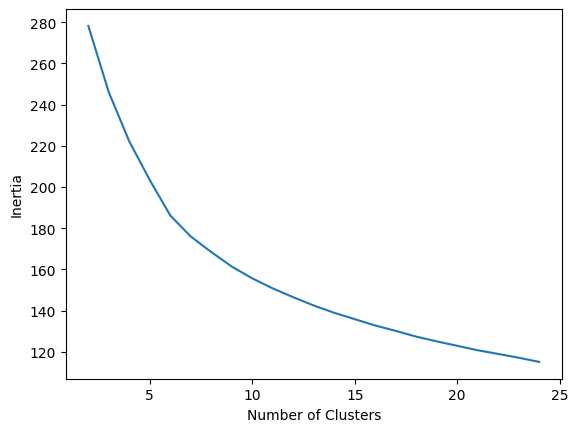

In [143]:
inertia = pd.DataFrame(clusters, columns = ["Clusters", "Inertia", "Silhouette Score"])

plt.plot(inertia["Clusters"], inertia["Inertia"])
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.savefig('/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/elbow.png')

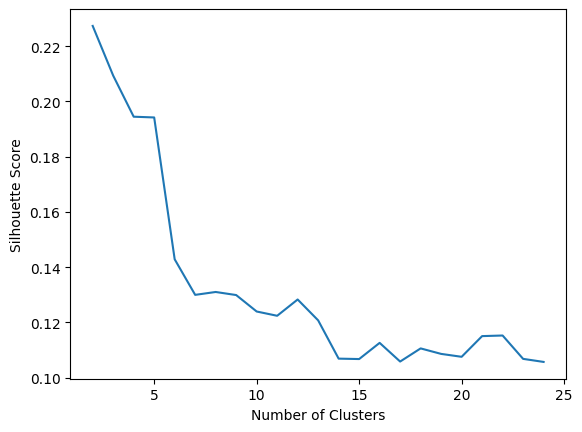

In [144]:
plt.plot(inertia["Clusters"], inertia["Silhouette Score"])
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.savefig('/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/silhouette.png')

In [137]:
k = KMeans(n_clusters=4, n_init=20)
k.fit(normalized_arr)
centroids = k.cluster_centers_

In [138]:
centroids

array([[0.00103891, 0.30405869, 0.01191722, 0.00683529, 0.00473849,
        0.63478116, 0.36178799, 0.60887691],
       [0.00076382, 0.29295652, 0.01133376, 0.00654241, 0.00452253,
        0.63749171, 0.41462513, 0.57790745],
       [0.00101502, 0.31758432, 0.01250739, 0.00721109, 0.00500701,
        0.5793256 , 0.47578502, 0.57658179],
       [0.00144842, 0.36926298, 0.01508884, 0.00890871, 0.00616665,
        0.40044591, 0.64702513, 0.51446765]])

In [ ]:
labels = k.labels_

In [ ]:
indices = np.expand_dims(labels, axis=1)

In [ ]:
np.argmax(normalized_arr, axis = 0)

array([9112, 1506, 3812, 1574, 3171,  865, 1635, 1635, 1635])

In [ ]:
np.argmax(new, axis = 0)

array([9105, 2076,   75, 4482, 2347, 3926, 4997, 7691, 4997])

In [ ]:
feature_copy = normalized_arr.copy()

In [ ]:
new = np.delete(feature_copy, [9112, 1506, 3812, 1574, 3171,  865, 1635], axis = 0)

In [ ]:
len(new)

9106

In [ ]:
sentences_key.shape

(9113, 5)

In [ ]:
new = np.concatenate((indices, sentences_key), axis=1)

In [ ]:
new9 = new[:,0] == 9

In [ ]:
new[new9][0:100]

array([[9, 0, 'That makes.', 0.0, 1.0, '220401_003_me.wav'],
       [9, 1,
        " But the, but the forms. I like the entire point of, like, the forms. It's our negation of the component forms are in a gation of, of reality of totally what I say, isn't the entire like concept of the Potomac forms, is that there's a reality more real than the real. The light above it from which everything is manufactured. From what?",
        1.0, 28.0, '220401_003_me.wav'],
       [9, 3,
        " In terms of it being so, yeah, but the only thing is that our reality, even our reality isn't.",
        40.0, 58.0, '220401_003_me.wav'],
       [9, 15, ' create precisely, you know, that is that is like',
        441.0, 448.0, '220401_003_me.wav'],
       [9, 16, " That's what is philosophy, man is kind of, you know.",
        450.0, 456.0, '220401_003_me.wav'],
       [9, 24,
        " Hello, for me know, thanks, and I know if you land feet first. Don't stare at the unbelievably.",
        658.0, 677.0, 

In [ ]:
new[2347]

array([2, 2347,
       " Oh, and you should eat something before then. That's when you eat breakfast oatmeal.",
       126.0, 133.0, '220328_002_me.wav'], dtype=object)

In [ ]:
new[7691]

array([9, 7691,
       " The highlight of my friends. I don't remember any good.", 186.0,
       239.0, '220225_005_me.wav'], dtype=object)

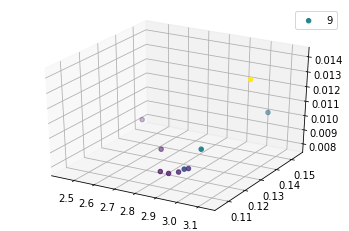

In [ ]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = centroids[:,0]
xdata = centroids[:,1]
ydata = centroids[:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata);
ax.legend(k.labels_)

In [ ]:
centroids

array([[5.51989049, 3.63373333, 5.48955644, 0.01027796, 2.96573133,
        0.11674844, 0.06637244, 0.04643333],
       [6.37363303, 3.90074292, 5.92257383, 0.00846362, 2.94848118,
        0.11236569, 0.06431177, 0.04467084],
       [3.7225253 , 4.79460784, 4.41615412, 0.01115541, 2.98003006,
        0.12201078, 0.07081117, 0.04908182],
       [7.19854078, 4.49995529, 6.30623069, 0.01063863, 2.96594291,
        0.11992065, 0.06732006, 0.04720666],
       [5.77196371, 4.54476715, 5.48210437, 0.00909116, 2.9595884 ,
        0.11472663, 0.06595638, 0.04599068]])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
new = pca.fit_transform(normalized_arr)
new

array([[-0.02765603,  0.05071891, -0.00174654],
       [-0.02964017,  0.02068073, -0.03062637],
       [-0.06375096,  0.0124968 , -0.00404775],
       ...,
       [-0.00164255, -0.00816316,  0.00923692],
       [ 0.01138012, -0.03791561,  0.03923946],
       [-0.0579111 , -0.01164567, -0.00188178]])

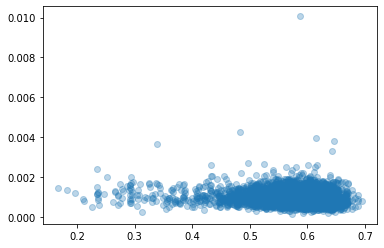

In [ ]:
plt.scatter(normalized_arr[:,0],normalized_arr[:,12], alpha=0.3)